In [29]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [30]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../data/benchmark-cluster/explodingLiquid/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        thread = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        if "Fuzzy" in tuning_algorithm:
            continue

        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not tuning_algorithm in data[scenario][thread]:
            data[scenario][thread][tuning_algorithm] = {}

        data[scenario][thread][tuning_algorithm][file_type] = df_tuners

Processing AutoPas_tuningResults_Rank0_2024-06-14_15-43-56.csv
../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_tuningResults_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_tuningData_Rank0_2024-06-14_15-43-56.csv
../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_tuningData_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-14_15-43-56.csv
../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_iterationPerformance_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_tuningResults_Rank0_2024-06-14_15-44-27.csv
Processing AutoPas_tuningData_Rank0_2024-06-14_15-44-27.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-14_15-44-27.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-14_15-45-00.csv
../../../data/benchmark-cluster/explodingLiquid/12/BayesianSearch AutoPas_iterationPerformance_Rank0_2024-06-14_15-45-00.csv
Processing AutoPas_tuningResults_Rank0_2

# Make Line Plot of Smoothed Value over Iterations


3.3682769236730277
2.927344601783185
2.7087376126989415
2.634741993000583
2.4878700736605284


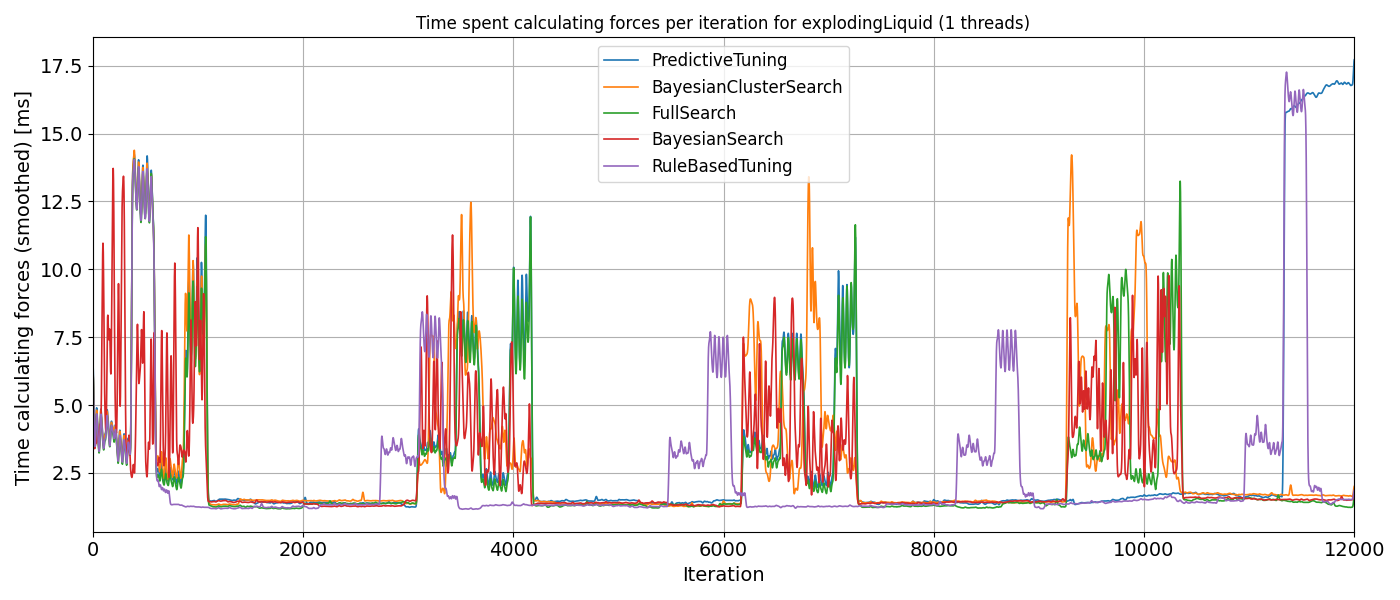

3.410780637280227
3.168244675360387
3.0955176075327056
2.943643884759604
2.9121489005916175


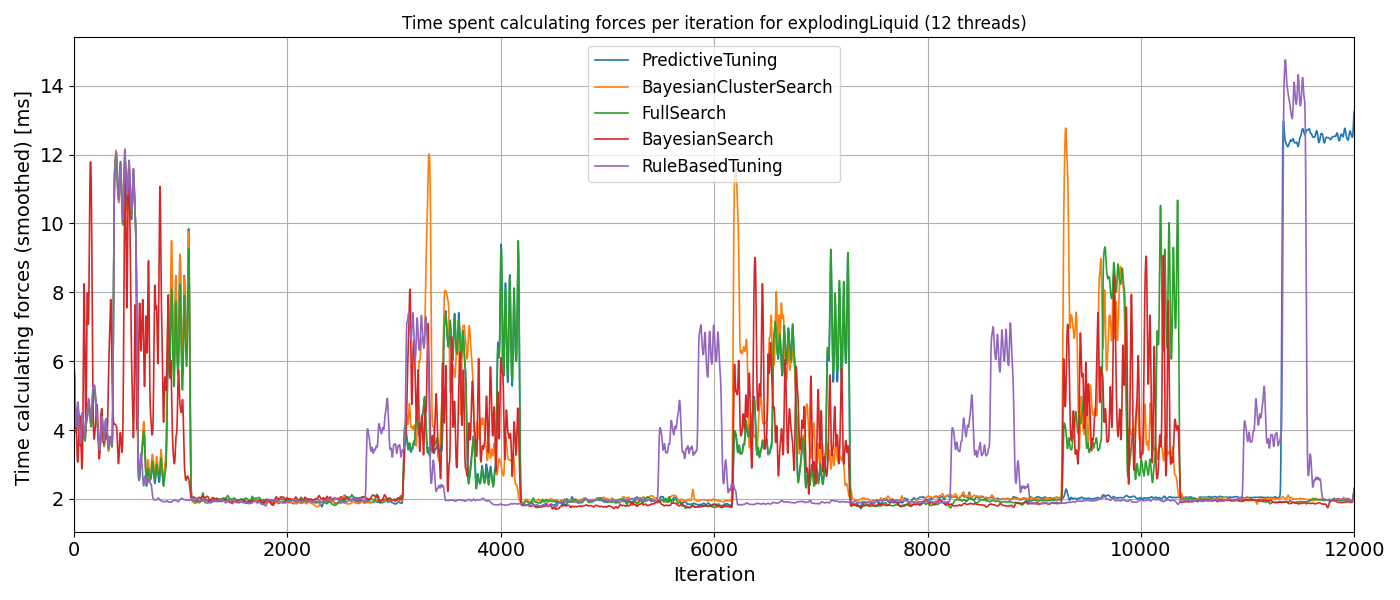

5.053583832763936
4.830223586534456
4.829050498875094
4.704005324389634
4.534660127322723


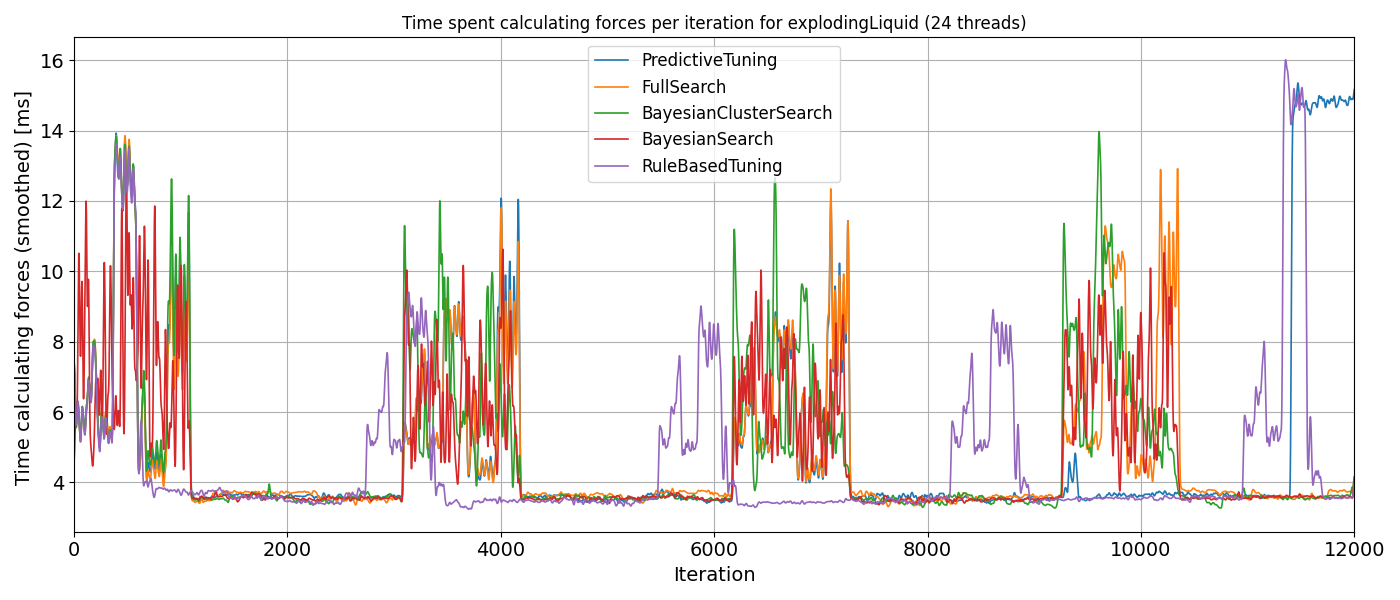

5.542091252395633
5.1340088470127485
5.132643746521124
4.789230667694359
4.687260191067411


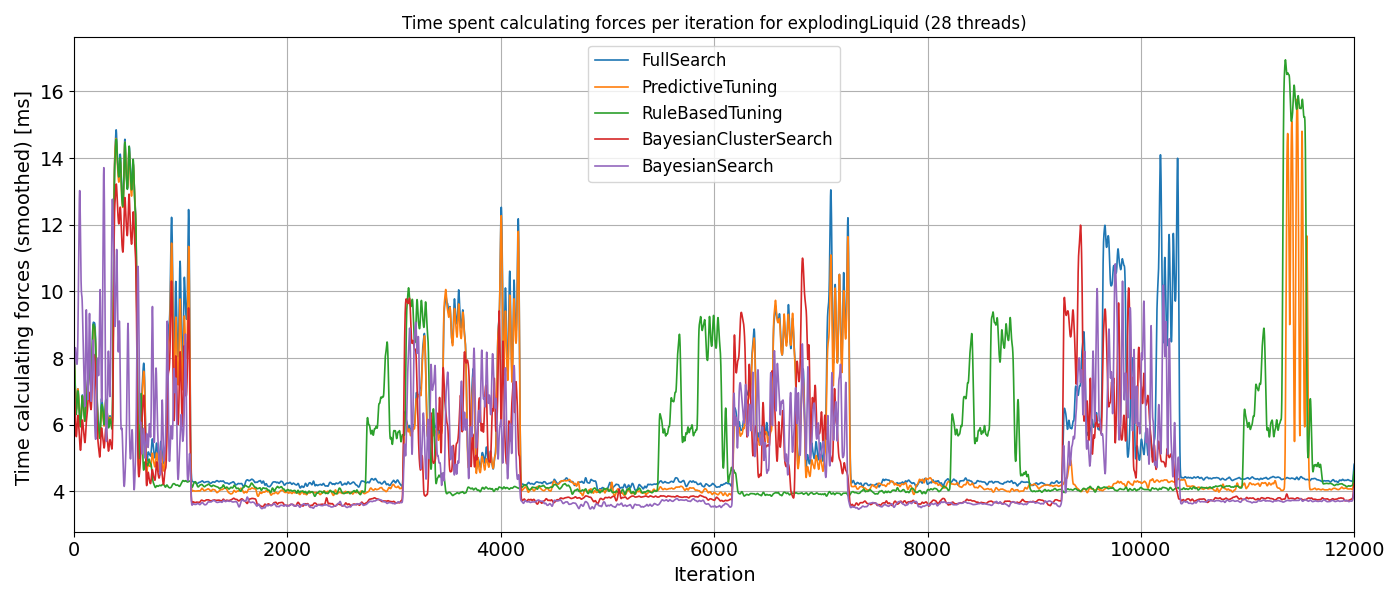

In [31]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items()):
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

            iteration_data = logs["iterationPerformance"]

            time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

            first_k = 1000000

            x = iteration_data["Iteration"][:first_k]
            y = time_s[:first_k] * 1000

            mean = y.mean()

            print(mean)

            # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

            if np.logical_or(np.isnan(y), np.isinf(y)).any():
                print(y)
                raise ValueError(f"Found NaN or Inf in {
                                 tuning_algorithm + threads + scenario}")

            smoother = ConvolutionSmoother(
                window_len=40, window_type='blackman')
            smoother.smooth(y)
            low, up = smoother.get_intervals('sigma_interval', n_sigma=0.04)

            linewidth = 1.2
            opacity = 1
            linestyle = "-"

            color = ax._get_lines.get_next_color()
            if "Suitability" in tuning_algorithm:
                color = "orangered"
            elif "Components" in tuning_algorithm:
                color = "royalblue"

            ax.plot(smoother.smooth_data[0], label=f"{
                    tuning_algorithm}", linewidth=linewidth, alpha=opacity, linestyle=linestyle, color=color)

            plt.grid()

        ax.legend(prop={'size': 12})
        ax.set_xlabel("Iteration")
        ax.set_ylabel(
            "Time calculating forces (smoothed) [ms] ")

        ax.set_xlim(0, 12000)

        # set y axis to mikro seconds

        ax.set_title(f"Time spent calculating forces per iteration for {
                     scenario} ({threads} threads)")
        # ax.set_xlim(0, df["Iteration"].max())
        # log

        # make y axis bigger
        ax.yaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        # make axis title bigger
        ax.yaxis.label.set_size(14)
        ax.xaxis.label.set_size(14)

        fig.tight_layout()

        # logarithmic scale
        # ax.set_yscale('log')

        plt.show()
        fig.savefig(f"timing_{scenario}_{threads}.png", dpi=300)